# rRNA quantification

Daniel asks from where the rRNA reads originate. I will tell him. 


In [13]:
# Rlibs
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
library(Rsamtools)

SHA-1 hash of file is 22fb06d671e2b067831995cd09e786560ab301f3


In [14]:
# load annotations
f = "/g/steinmetz/brooks/yeast/annotations/SGD_features.rda"
if (!file.exists(f)) {
    annotations = read.delim("/g/steinmetz/brooks/yeast/annotations/SGD_features.txt", 
                             sep="\t", header = F, stringsAsFactors = F)
    colnames(annotations) = c("SGDID", "FEATURE_TYPE", "FEATURE_QUALIFIER",
                             "FEATURE_NAME", "GENE_NAME", "ALIAS",
                             "PARENT_FEATURE_NAME", "SECONDARY_SGDID",
                             "CHROMOSOME", "START", "STOP",
                             "STRAND", "GENETIC_POSITION","COORDINATE_VERSION",
                             "SEQUENCE_VERSIONS", "DESCRIPTION")
    annotations$CHROMOSOME = paste("chr", str_pad(annotations$CHROMOSOME, 2, pad = "0"), sep = "")
    annotations$STRAND = as.character(annotations$STRAND)
    annotations[which(annotations$STRAND == "W"),"STRAND"]= "+"
    annotations[which(annotations$STRAND == "C"),"STRAND"]= "-"
    annotations$START = as.numeric(annotations$START)
    annotations$END = as.numeric(annotations$END)
    save(annotations, file = f)
} else {
    load(f)
    # modify annotations so that start < end
    tochange = which(annotations$START > annotations$STOP)
    if (length(tochange) > 0) {
        tmp = annotations[tochange,]
        annotations[tochange,"START"] = tmp$STOP
        annotations[tochange,"STOP"] = tmp$START
    }
}

In [20]:
S1 = "/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/BY4741.bam"
S2 = "/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/BY4741neo.bam"
S3 = "/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/triplesyn.bam"
S4 = "/g/steinmetz/project/IESY/trna/results/2016-08-19-HG3W5AFXX/triplesynNeo.bam"

In [21]:
bamf = BamFileList(c(S1,S2,S3,S4))

In [22]:
# rRNA GRanges object
this = annotations %>% filter(FEATURE_TYPE == "rRNA_gene")
this = data.frame(chrom = this$CHROMOSOME, start = this$START, 
                    end = this$STOP, strand = this$STRAND, 
                    seqinfo = this$FEATURE_NAME)
rrnas = as(this,"GRanges")

In [23]:
rrna_counts = countBam(bamf, param=ScanBamParam(which = rrnas))
rrna_counts$type = "rRNA"

In [34]:
samples = sapply(rownames(rrna_counts), function(i)strsplit(i,"\\.")[[1]][1])
rrna_counts$sample = samples

In [38]:
counts = merge(rrna_counts,as.data.frame(rrnas),
               by.x = c("space","start","end","width"), by.y=c("seqnames","start","end","width"))

# Figure 1: Bowtie Alignments

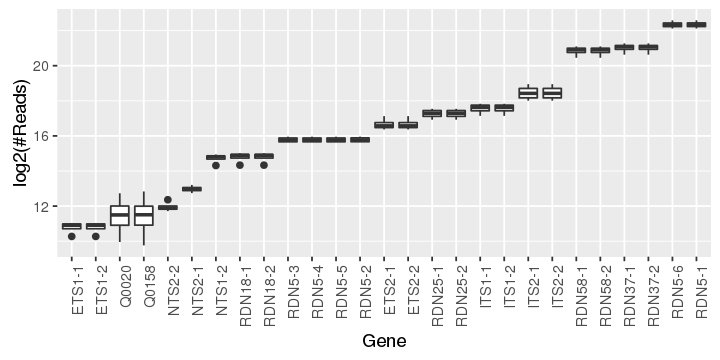

In [50]:
options(repr.plot.width = 6)
options(repr.plot.height = 3)
p <- ggplot(counts, aes(fct_reorder(factor(seqinfo), log2(records)), log2(records)))

p + geom_boxplot() +
    ylab("log2(#Reads)") +
    xlab("Gene") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Now on a normal scale (for emphasis) :)

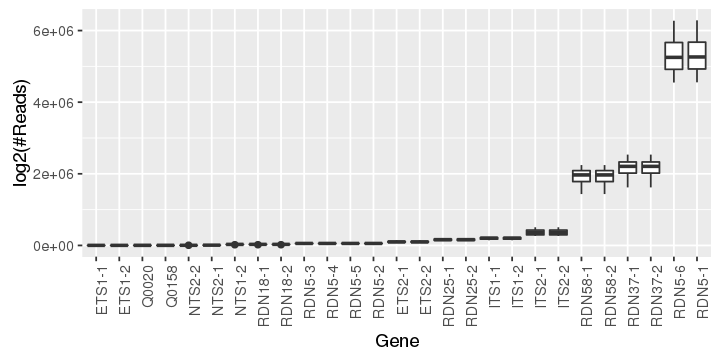

In [49]:
options(repr.plot.width = 6)
options(repr.plot.height = 3)
p <- ggplot(counts, aes(fct_reorder(factor(seqinfo), log2(records)), (records)))

p + geom_boxplot() +
    ylab("log2(#Reads)") +
    xlab("Gene") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Compare to normalized counts from ARMseq via DESeq2

In [94]:
BY4741 = read_tsv("/home/brooks/IESY/trna/results/2016-08-19-HG3W5AFXX/BY4741/BY4741-ARMseq-normalized.txt", 
                  skip = 1, col_names = c("Name", "BY4741neo", "BY4741"))
triplesyn = read_tsv("/home/brooks/IESY/trna/results/2016-08-19-HG3W5AFXX/triplesyn/triplesyn-ARMseq-normalized.txt", 
                  skip = 1, col_names = c("Name", "triplesynNeo", "triplesyn"))
armseqcounts = merge(BY4741,triplesyn,by="Name")
armseqcounts = melt(armseqcounts,variable.name = "Sample")
ncrna_armseqcounts = armseqcounts[!grepl("^chr|^tRNA",armseqcounts$Name),]

Parsed with column specification:
cols(
  Name = col_character(),
  BY4741neo = col_double(),
  BY4741 = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  triplesynNeo = col_double(),
  triplesyn = col_double()
)
Using Name as id variables


# Figure 2: DESeq normalized counts

Warning message:
: Removed 49 rows containing non-finite values (stat_boxplot).

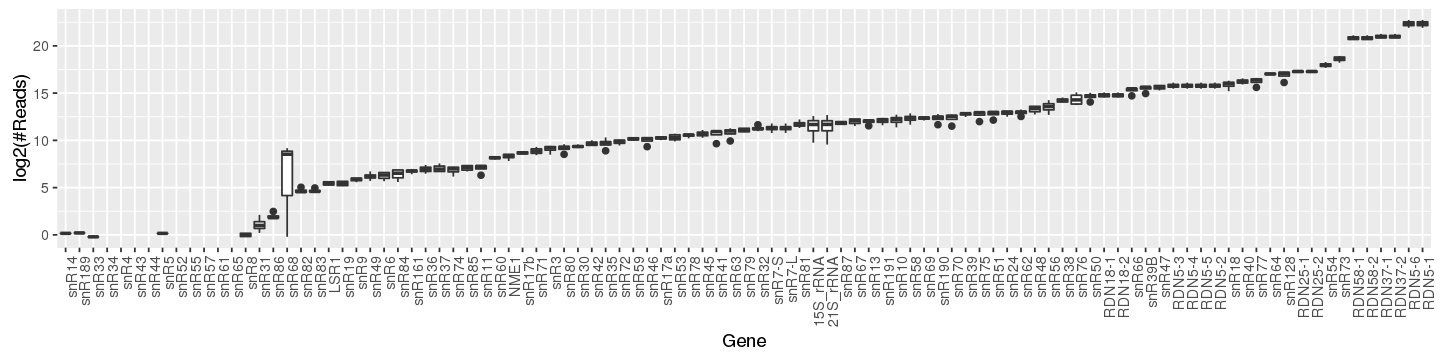

In [98]:
options(repr.plot.width = 12)
options(repr.plot.height = 3)
p <- ggplot(ncrna_armseqcounts, aes(fct_reorder(factor(Name), log2(value)), log2(value)))

p + geom_boxplot() +
    ylab("log2(#Reads)") +
    xlab("Gene") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

# BAM with ncRNA gene definitions above

In [109]:
# rRNA GRanges object
this2 = annotations %>% filter(FEATURE_NAME %in% unique(ncrna_armseqcounts$Name))
this2 = data.frame(chrom = this2$CHROMOSOME, start = this2$START, 
                    end = this2$STOP, strand = this2$STRAND, 
                    seqinfo = this2$FEATURE_NAME)
ncrnas = as(this2,"GRanges")

In [110]:
ncrna_counts = countBam(bamf, param=ScanBamParam(which = ncrnas))

In [111]:
ncrna_counts$sample = samples

ERROR: Error in `$<-.data.frame`(`*tmp*`, "sample", value = structure(c("BY4741", : replacement has 108 rows, data has 388


In [112]:
ncrna_counts = merge(ncrna_counts,as.data.frame(ncrnas),
               by.x = c("space","start","end","width"), by.y=c("seqnames","start","end","width"))

# Figure 3: Bowtie Alignments with expanded ncRNA definitions

Warning message:
: Removed 40 rows containing non-finite values (stat_boxplot).

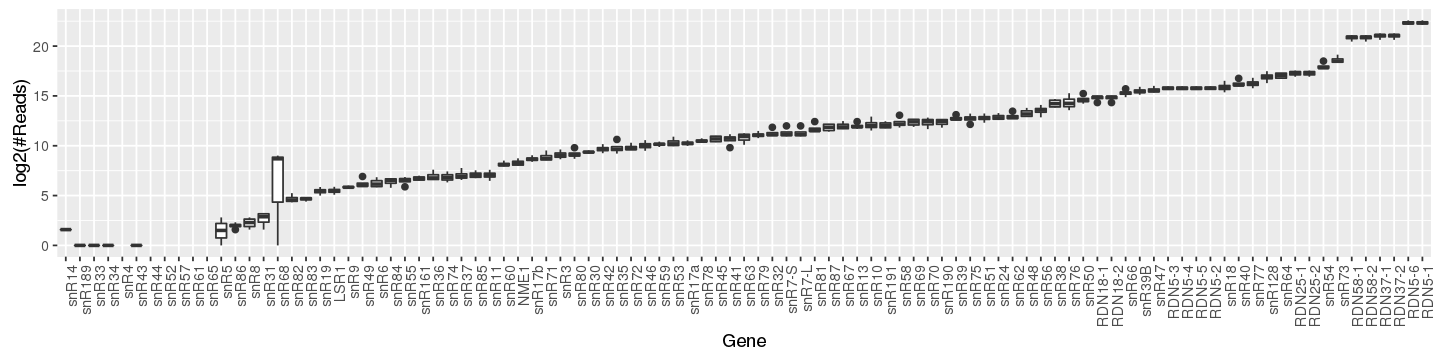

In [114]:
options(repr.plot.width = 12)
options(repr.plot.height = 3)
p <- ggplot(ncrna_counts, aes(fct_reorder(factor(seqinfo), log2(records)), log2(records)))

p + geom_boxplot() +
    ylab("log2(#Reads)") +
    xlab("Gene") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))